# Project 4 : Job Market Analysis

### Notebook 02: Data Cleaning and Exploratory Analysis

---

## Contents
- [1.0 Introduction](#Intro)
- [2.0 Exploratory Data Analysis](#eda)
    - [2.1 Reading the data](#data)
    - [2.2 Extract meaningful job titles](#titles)
    - [2.3 Binning job industries](#industries)
    - [2.4 Extract required experience](#experience)
    - [2.5 Extract salary figures](#salary)
    - [2.6 Exploring the data](#explore)
- [3.0 Impute the Missing Salaries](#impute)
- [4.0 Next Steps](#next)


## 1.0 Introduction <a name="Intro"></a>
The goal of this project is to answer the following questions:
1. Which factors in the job market have the most affect on salary?
2. Is it possible to identify the key skills and buzzwords across job category / title?

In order to answer the above questions, I will gather data from the job search site [SEEK Limited AU](https://www.seek.com.au/). For this project I will limit the study to available jobs in data related fields (e.g. data science, data analyst etc) in the Sydney and Melbourne areas.

I will be splitting this project in 3 notebooks as follows:
- Notebook 01: Data Gathering (Web Scrape)
- **Notebook 02: Data Cleaning and Exporatory Analysis**
- Notebook 03: Predictive Model Building

In [1]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## 2.0 Exploratory Data Analysis <a name="eda"></a>
### 2.1 Reading the data <a name="data"></a>
Below I will read the dataset I scraped off the web, and see how many job postings we have:

In [2]:
# Reading scraped csv file
seek = pd.read_csv('./datasets/seekjobs.csv', index_col=0).reset_index(drop=True)
seek.dropna(how='all', inplace=True)
print('Count of Jobs in Full Scrape: {:,}'.format(seek.shape[0]))

Count of Jobs in Full Scrape: 14,132


In [3]:
seek.head(3)

,searched_job,searched_city,job_title,advertiser,advertiser_rating,date_posted,salary,work_type,category,subcategory,job_description,url
0,data-analyst,All-Sydney-NSW,Data Analyst (Digital),Seventh Street Ventures,NaN,23-Apr-19,"$60,000 - $70,000 plus Super",Contract/Temp,Information & Communication Technology,Business/Systems Analysts,About Us Seventh Street Ventures is an entrepr...,https://www.seek.com.au/job/38866940?type=prom...
1,data-analyst,All-Sydney-NSW,Data Quality Analyst - Oracle Enterprise Data ...,Capgemini,2.7,2-May-19,NaN,Full Time,Information & Communication Technology,Engineering - Software,About the Team\r\nOur Insights and Data team h...,https://www.seek.com.au/job/38929211?type=stan...
2,data-analyst,All-Sydney-NSW,Data Analyst,PwC,3.7,3-May-19,NaN,Contract/Temp,Information & Communication Technology,Database Development & Administration,Line of Service Assurance Industry/Sector Ban...,https://www.seek.com.au/job/38938169?type=stan...


As with any job search site, I know there will be many jobs which do not directly relate to data science, data analysis or data engineering. These will also need to be filtered and removed. I will filter out the unrelated jobs later in this notebook.

### 2.2 Extract meaningful job titles <a name="titles"></a>
We know that the wordings of job titles posted by advertisers vary vastly from job to job. To be able to do any meaningful analysis, I will extract meaningful job titles from the advertised titles using a brute-force search-word methodology.

Once I have extracted the clean job titles, it will also allow me to filter out the jobs not related to data which are out of the scope of this project. The search will give me a *None* for job postings not matching any of my search parameters, which I will remove from the dataframe.

In [4]:
# Function for keyword search of relevant job postings
def refined(x):
    x = x.lower()
    if any(word in x for word in ['data scientist', 'statistician', 'big data']):
        return 'data scientist'
    elif any(word in x for word in ['analy']):
        if 'data entry' in x:
            return None
        elif any(word in x for word in ['business', 'bi ', 'insights', 'customer', 'intelligence']):
            return 'business analyst'
        elif any(word in x for word in ['etl', 'data', 'implementation', 'reporting', 'model', 'quantitat']):
            return 'data analyst'
    elif 'business' in x:
        return 'business analyst'
    elif any(word in x for word in ['data engineer', 'data migration', 'data governance', 'data modeller']):
        return 'data engineer'
    else:
        return None

In [5]:
# Filter out unrelated job postings
print('Total jobs before filter: {:,}'.format(seek.shape[0]))
seek['new_job_title'] = seek['job_title'].map(refined)
seek = seek[~seek['new_job_title'].isnull()].reset_index(drop=True)
print('Total jobs after filter: {:,}'.format(seek.shape[0]))

print('\nCounts of Refined Jobs:')
print('------------------------')
print(seek['new_job_title'].value_counts())

Total jobs before filter: 14,132
Total jobs after filter: 2,821

Counts of Refined Jobs:
------------------------
new_job_title
business analyst    1780
data analyst         596
data scientist       271
data engineer        174
Name: count, dtype: int64


Out of the original approximately 10 thousand job postings, we now have distilled to a little above 2,000 relevant jobs. We can also see that there is a signficantly higher demand of Business Analysts and Data Analysts in the Sydney / Melbourne region as compared to other other data jobs. I will go into more detail on these points later in this notebook during EDA and analysis.

### 2.3 Binning job industries <a name="industries"></a>
Based on the output below, we can already see that Information & Communication Technology has the most job postings for data related jobs, which makes perfect sense. However the remaining categories have less to near-nonexistant representation. To be able to make the analysis easier and reduce dimensionality, I will bin these industries into logical groups.

In [6]:
seek['category'].value_counts()

category
Information & Communication Technology    1818
Sales                                      188
Banking & Financial Services               180
Accounting                                 151
Science & Technology                        79
Consulting & Strategy                       76
Marketing & Communications                  73
Government & Defence                        45
Human Resources & Recruitment               36
Insurance & Superannuation                  26
Administration & Office Support             25
Manufacturing, Transport & Logistics        22
Education & Training                        19
Healthcare & Medical                        17
Advertising, Arts & Media                   10
Real Estate & Property                       9
Community Services & Development             9
CEO & General Management                     6
Retail & Consumer Products                   6
Mining, Resources & Energy                   5
Call Centre & Customer Service               5
Engi

In [7]:
def industry(x):
    if any(kw in x for kw in ['Information & Communication Technology', 'Consulting & Strategy']):
        return 'information_technology'
    elif any(kw in x for kw in ['Science & Technology', 'Manufacturing, Transport & Logistics',
                                'Engineering', 'Mining, Resources & Energy', 'Construction',
                                'Design & Architecture']):
        return 'science_technology'
    elif any(kw in x for kw in ['Banking & Financial Services', 'Accounting', 'Insurance & Superannuation']):
        return 'financial_services'
    elif any(kw in x for kw in ['Government & Defence', 'Healthcare & Medical', 'Community Services & Development']):
        return 'gov_health'
    elif any(kw in x for kw in ['Sales', 'Marketing & Communications', 'Retail & Consumer Products']):
        return 'sales_marketing'
    else:
        return 'other'
    
seek['new_category'] = seek['category'].map(industry)
seek['new_category'].value_counts()

new_category
information_technology    1894
financial_services         357
sales_marketing            267
other                      119
science_technology         113
gov_health                  71
Name: count, dtype: int64

### 2.4 Extract required experience <a name="experience"></a>
Salaries generally scale up based on the required level of experience. Unfortunately, this information is not present in the data in a way that can be easily extracted. Again, I will try to do a keyword-search to find if I can extract any information regarding the experience requirement of the advertised job.

In [8]:
# Extracting seniority from title
def experience(x):
    x = x.lower()
    if 'junior' in x:
        return '1 Junior'
    elif 'senior' in x:
        return '3 Senior'
    elif 'manager' in x or 'head' in x:
        if 'to manager' not in x:
            return '3 Senior'
    else:
        return '2 Mid-Level'

seek['exp_level'] = seek['job_title'].map(experience)
seek['exp_level'].value_counts(dropna=False)

exp_level
2 Mid-Level    1997
3 Senior        769
1 Junior         55
Name: count, dtype: int64

The distribution is heavily skewed towards the mid-level jobs. This is because I assumed a mid-level requirement where experience level was not available in the job title. We will see during EDA if this gives any meaning to our salary prediction.

### 2.5 Extract salary figures <a name="salary"></a>
Looking through the job advertisements, I can make some observations as below:
1. Salaries are mentioned either in the 'Salary' section, 'Job Title' section or 'Job Description' section. For this I will search through all three columns and extract the salary.
2. Salaries are given either per hour, per day, per week, or annual. I will use a keyword search to extract this detail as a separate feature. Moreover, using this information I will convert all salaries to annual for comparative and prediction purpose.

In [9]:
def get_sal(txt, gets='sal'):  # Give 'sal_type' to get salary type
    # Get Pay Type
    if any(word in txt for word in ['/day', '/ day', 'p/d', 'pd', 'p.d', 'daily', 'per day']):
        pay_type = 'day'
    elif any(word in txt for word in ['week', 'p.w', 'p/w']):
        pay_type = 'week'
    elif any(word in txt for word in ['ph ','p.h', 'p/h', 'h/r', 'per hour']):
        pay_type = 'hour'
    else:
        pay_type = 'year'
    
    # Replace symbols & keywords
    txt = txt.replace(',', '')
    
    for kw in ['000k', '000k+', 'k ', 'k+']:
        txt = txt.lower().replace(kw, '000 ') 
        
    for kw in ['-','(',')', '$', '/']:
        txt = txt.replace(kw, ' ')
        
    numbers = []
    pay_dict = {'hour': 8*260, 'day': 260, 'week': 52, 'year': 1}

    for w in txt.split():
        try:
            sal = float(w)
            numbers.append(sal * pay_dict[pay_type])
        except:
            continue

    if len(numbers) > 0:
        if max(numbers) > 30000 and max(numbers) < 300000:
            if gets=='sal_type':
                return pay_type
            else:
                return max(numbers)
    else:
        return None

In [10]:
# Fill null values with 'na' to be able to run function
seek['salary'] = seek['salary'].map(lambda x: 'na' if pd.isnull(x) else x) 

# Extract Salary from Salary / Title / Description columns
seek['salary_from_salary'] = seek['salary'].map(lambda x: get_sal(x))
seek['salary_from_title'] = seek['job_title'].map(lambda x: get_sal(x))
seek['salary_from_desc'] = seek['job_description'].map(lambda x: get_sal(x))
seek['final_salary'] = seek[['salary_from_salary', 'salary_from_title', 'salary_from_desc']].max(axis=1)

# Extract Salary Type from Salary / Title / Description columns
seek['sal_type1'] = seek['salary'].map(lambda x: get_sal(x, gets='sal_type'))
seek['sal_type2'] = seek['job_title'].map(lambda x: get_sal(x, gets='sal_type'))
seek['sal_type3'] = seek['job_description'].map(lambda x: get_sal(x, gets='sal_type'))

# Merge salary type from the above three columns
sal_types = []
for tup in seek[['sal_type1', 'sal_type2', 'sal_type3']].itertuples():
    found = 0
    for typ in [tup.sal_type1, tup.sal_type2 ,tup.sal_type3]:
        if typ!=None and found==0:
            sal_types.append(typ)
            found += 1
    if found==0:
        sal_types.append(None)
        
seek['salary_type'] = sal_types

# Drop all extra created columns
seek = seek.drop(['salary_from_salary', 'salary_from_title', 'salary_from_desc', 
                                    'sal_type1', 'sal_type2', 'sal_type3'], axis=1)

In [11]:
av_sals = seek[~seek['final_salary'].isnull()].shape[0]

print('Job postings with salaries:', av_sals)
print('Job postings without salaries: {:,}'.format(seek.shape[0] - av_sals))
print('Percentage of total job posts with salaries mentioned: {:.1f}%'.format(av_sals / seek.shape[0] * 100))

Job postings with salaries: 906
Job postings without salaries: 1,915
Percentage of total job posts with salaries mentioned: 32.1%


We only have about one-third of jobs which mention a salary. The majority of job postings do not have any information about the salary. After completing the EDA, I will try to impute these missing salaries based on the available salaries for the same title and industry to give an approximate figure.

### 2.6 Exploring the data <a name="explore"></a>
Time for a dive into what story the data tells us. Let us first subset only the features we require, then make some plots.

In [12]:
data = seek[seek['final_salary'].notnull()][['searched_city', 'new_job_title', 'exp_level', 'new_category',
                                             'date_posted', 'work_type', 'final_salary', 'salary_type']]

data.head()

,searched_city,new_job_title,exp_level,new_category,date_posted,work_type,final_salary,salary_type
0,All-Sydney-NSW,data analyst,2 Mid-Level,information_technology,23-Apr-19,Contract/Temp,70000.0,year
1,All-Sydney-NSW,data analyst,2 Mid-Level,information_technology,2-May-19,Full Time,200000.0,year
3,All-Sydney-NSW,business analyst,2 Mid-Level,information_technology,2-May-19,Full Time,150000.0,year
5,All-Sydney-NSW,data analyst,2 Mid-Level,other,3-May-19,Full Time,85000.0,year
16,All-Sydney-NSW,data analyst,2 Mid-Level,information_technology,2-May-19,Contract/Temp,194478.0,year


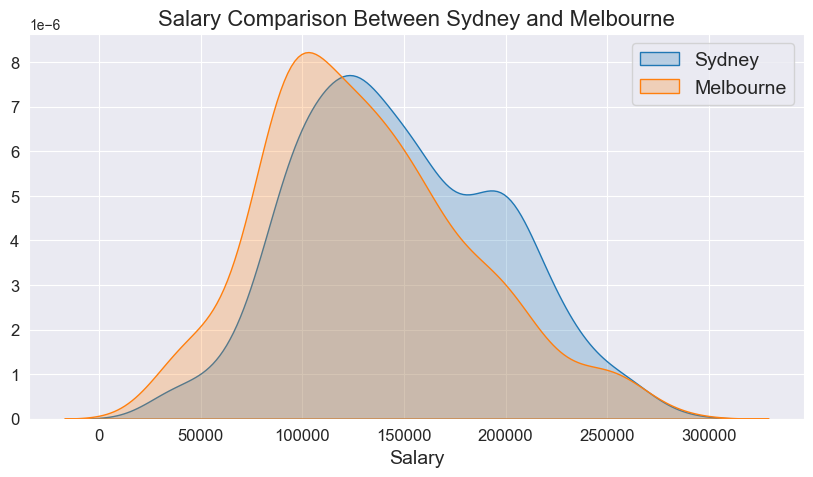

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for city in ['Sydney', 'Melbourne']:
    sns.kdeplot(data[data['searched_city'].str.contains(city)]['final_salary'], shade=True, ax=ax, label=city)

plt.title('Salary Comparison Between Sydney and Melbourne', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Salaries for Sydney are SLIGHTLY higher on average then for Melbourne, as can be seen from the distributions of the above charts.

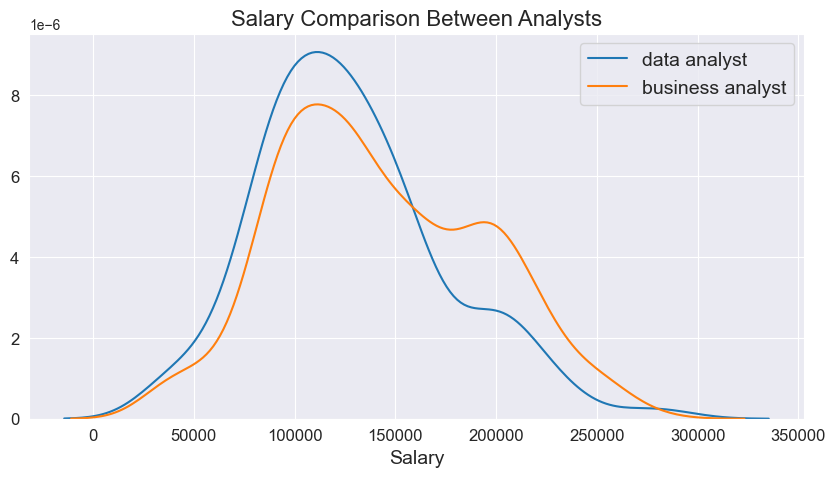

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for job in data['new_job_title'].unique()[:2]:
    sns.kdeplot(data[data['new_job_title']==job]['final_salary'], shade=False, ax=ax, label=job)

plt.title('Salary Comparison Between Analysts', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Data and business analysts have similar salaries on average, however the distribution for business analysts have a slightly higher spread hinting at a larger ratio of highly paid professionals.

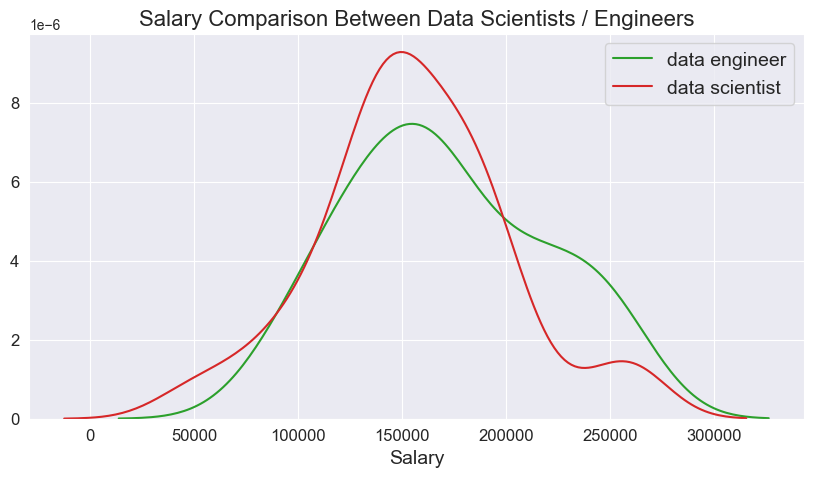

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
cols = ['C2','C3']
for i, job in enumerate(data['new_job_title'].unique()[2:4]):
    sns.kdeplot(data[data['new_job_title']==job]['final_salary'], shade=False, ax=ax, label=job, color=cols[i])

plt.title('Salary Comparison Between Data Scientists / Engineers', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Data scientists and data engineers also exhibit similar salaries on average, with data engineers having a slightly wider distribution.

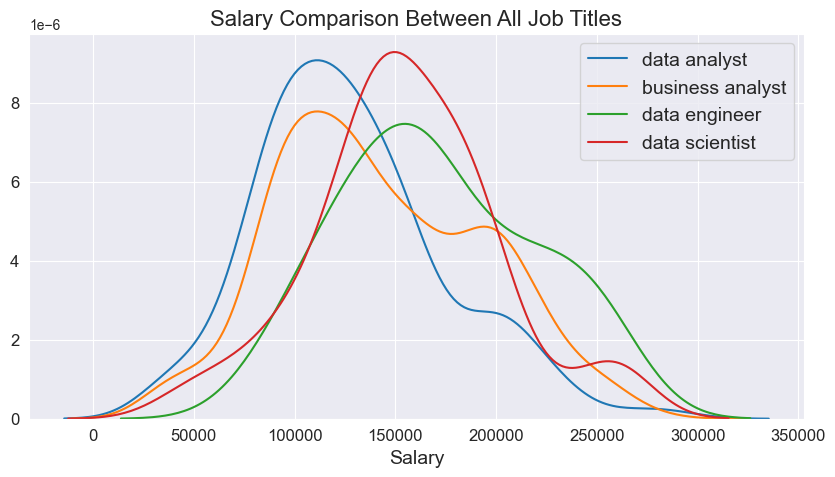

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for job in data['new_job_title'].unique():
    sns.kdeplot(data[data['new_job_title']==job]['final_salary'], shade=0, ax=ax, label=job)

plt.title('Salary Comparison Between All Job Titles', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

Overlaying all together, we can clearly see that Data Scientists and Data Engineerings generally get paid higher than Data and Business Analysts.

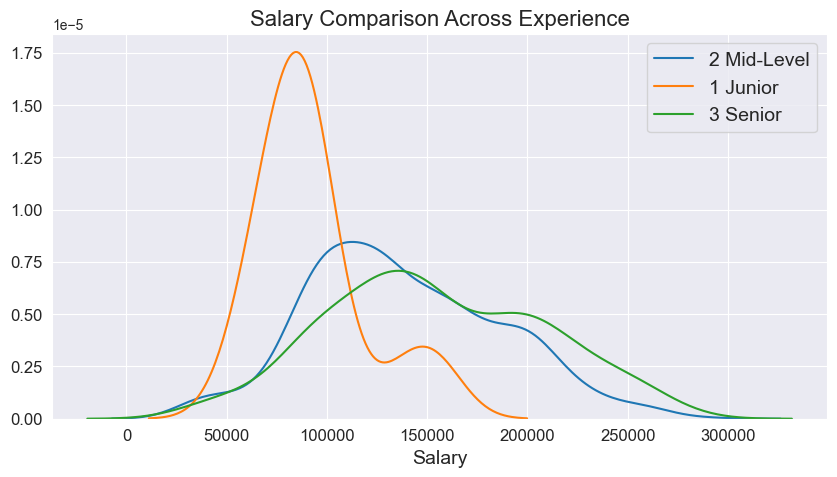

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for exp in data['exp_level'].unique():
    sns.kdeplot(data[data['exp_level']==exp]['final_salary'], shade=0, ax=ax, label=exp)

plt.title('Salary Comparison Across Experience', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

As expected, salary increases as the seniority requirement increases. Again, the lack of a significant difference between Mid-level and Senior is mostly due to the fact that many senior-level jobs did not have a clearly stated seniority requirement in the title itself, hence were considered to be Mid-level.

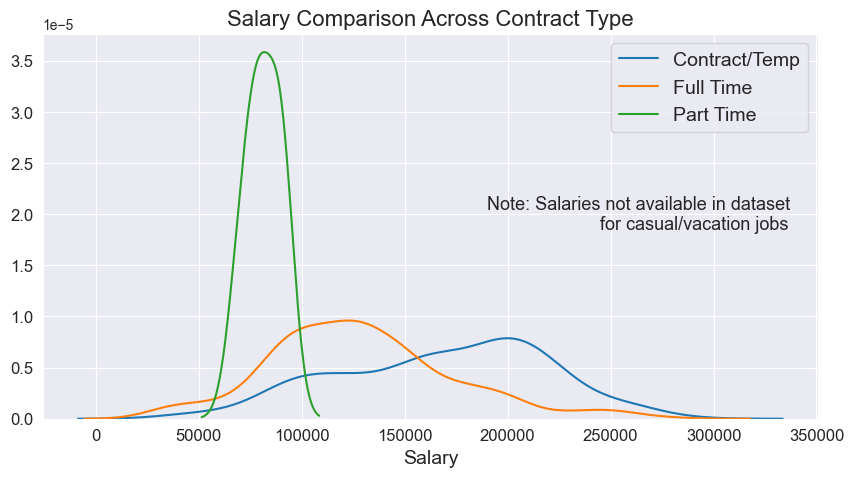

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for work in data['work_type'].unique():
    sns.kdeplot(data[data['work_type']==work]['final_salary'], shade=0, ax=ax, label=work)

plt.title('Salary Comparison Across Contract Type', fontsize=16)
plt.xlabel('Salary', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.text(190000, 0.0000205, 'Note: Salaries not available in dataset', fontsize=13)
plt.text(245000, 0.0000185, 'for casual/vacation jobs', fontsize=13)
plt.show()

We can see that part-time jobs have much lower salaries as expected. Also, contract jobs are paid higher as compared to full-time positions.

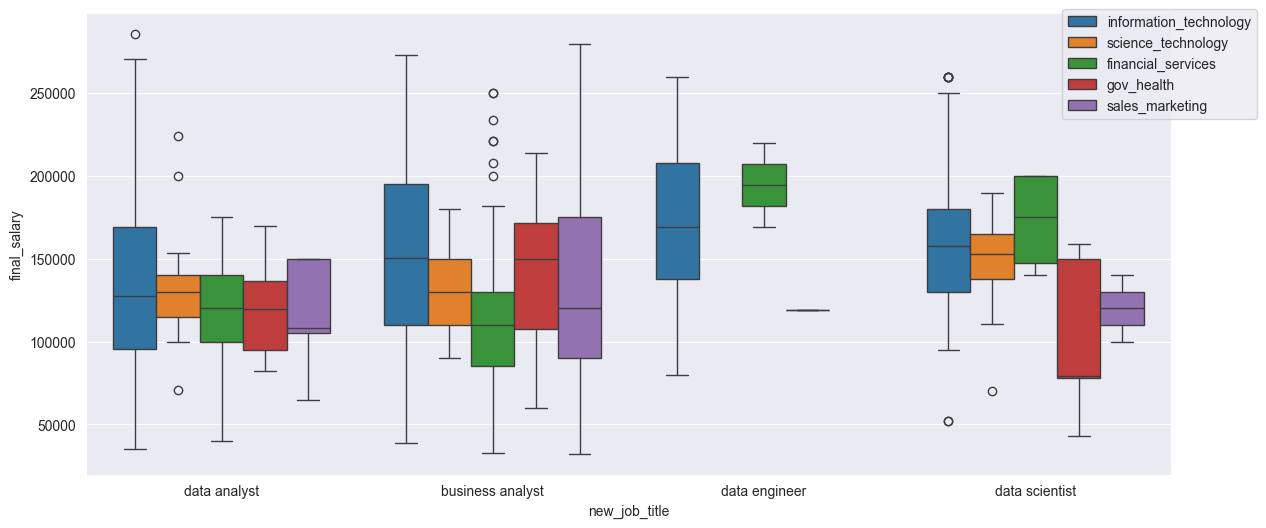

In [19]:
fig = plt.figure(figsize=(14,6))
sns.boxplot(x='new_job_title', y='final_salary', hue='new_category', data=data[data['new_category']!='other'])
plt.legend(loc=(0.9, 0.77))
plt.show()

Information Technology seems to have a wider spread of salary range for all job titles. This may be because of the higher count of observations there are available for this category. Additionally, it can also be seen that data scientists on average make higher salaries than analysts, and data engineers even more so.

Let us try to make a different chart for comparison of job titles against industry, which takes into account the number of available jobs as well to give us a better perspective.

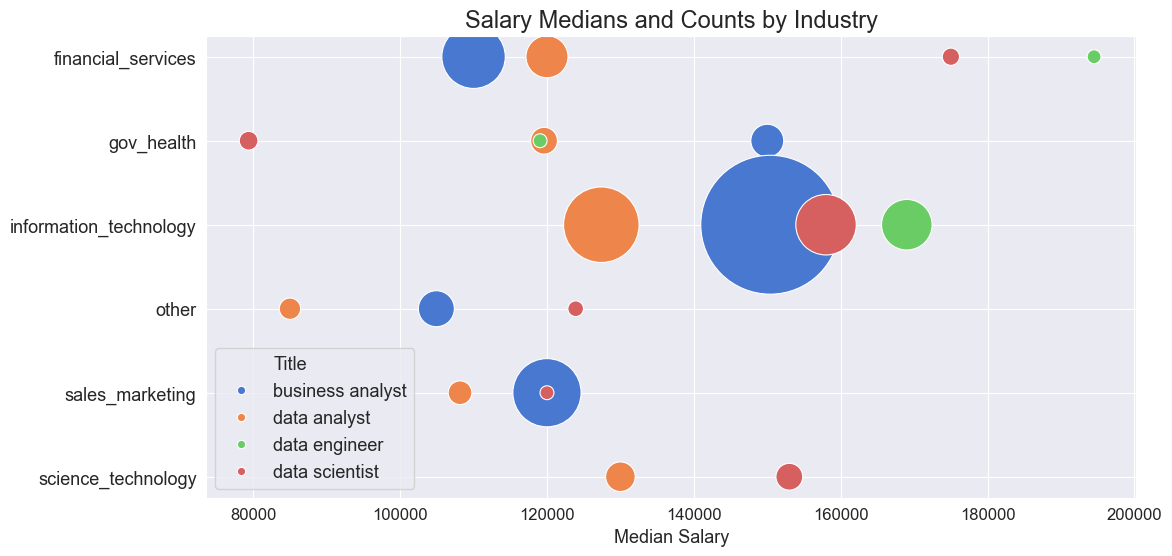

In [20]:
# Create group for Median Salary and Job Counts
grouped_data = pd.DataFrame(data.groupby(['new_category', 'new_job_title'])['final_salary'].median())
grouped_data = pd.concat([grouped_data, data.groupby(['new_category', 'new_job_title'])['work_type'].count()], axis=1)
grouped_data.reset_index(inplace=True)
grouped_data.columns = ['Industry', 'Title', 'Salary', 'Counts']

# Bubble plot for grouped data
plt.figure(figsize=(12,6))
sns.scatterplot(y='Industry', x='Salary', data=grouped_data, hue='Title', size='Counts', \
                sizes=(100, 10000), alpha=1, palette='muted', legend='brief')
plt.title('Salary Medians and Counts by Industry', fontsize=17)
plt.ylabel('')
plt.xlabel('Median Salary', fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

ax = plt.gca()
h,l = ax.get_legend_handles_labels()
ax.legend(h[:5],l[:5], fontsize=13)

plt.show()

The above graph combines the observations for industry, median salaries, job titles and number of available jobs. Some inferences can be made as follows:
1. For small bubbles, the graph cannot be safely assumed to be depicting the market norm for salaries (due to small number of observations).
2. Most of the jobs are available for analysts in the IT industry, and are paid fairly well in comparison to others.
3. Data Engineers are generally paid higher than data scientists across different industries.
4. Information Technology seems have a stable distrubution of salary offerings, possibly due to higher demand.

## 3.0 Impute the Missing Salaries <a name="impute"></a>
We have already seen above that most of the salaries in the available data are missing. It will not be possible to built a predictive model based on the data available to us. In order to fill the missing salary values, I will use the median salaries for the respective title and industry available in the data.

In [21]:
data_missing = seek[seek['final_salary'].isnull()][['searched_city', 'new_job_title', 'exp_level', 'new_category',
                                             'date_posted', 'work_type', 'final_salary', 'salary_type']]

data_missing.head(3)

,searched_city,new_job_title,exp_level,new_category,date_posted,work_type,final_salary,salary_type
2,All-Sydney-NSW,data analyst,2 Mid-Level,information_technology,3-May-19,Contract/Temp,NaN,None
4,All-Sydney-NSW,data analyst,2 Mid-Level,information_technology,30-Apr-19,Contract/Temp,NaN,None
6,All-Sydney-NSW,data analyst,2 Mid-Level,information_technology,2-May-19,Full Time,NaN,None


In order to capture as much granularity as possible, I will be imputing using 3 passes. The subsequent passes after the first are to capture any remaining missing salaries in case a salary is not available in the first pass for that unique combination of features.
1. First Pass: using the median salary from unique group of job title, industry and contract type
2. Second Pass: using the median salary from unique group of job title and industry
3. Third Pass: using the median salary from job title

In [22]:
print('Results before imputation : {:,} available, {:,} missing'.format(data.shape[0], data_missing.shape[0]))

# Pass 1 (try to impute using title, industry and contract type)
for x, y, z in product(seek['new_job_title'].unique(), seek['new_category'].unique(), seek['work_type'].unique()):
    mask1, mask_1 = data_missing['new_job_title']==x, data['new_job_title']==x
    mask2, mask_2 = data_missing['new_category']==y, data['new_category']==y
    mask3, mask_3 = data_missing['work_type']==z, data['work_type']==z
    data_missing.loc[mask1 & mask2 & mask3, 'final_salary'] = data.loc[mask_1 & mask_2 & mask_3, 'final_salary'].median()
    
data = pd.concat([data, data_missing]) # Merge the dataframes after imputation first pass

data_missing = data[data['final_salary'].isnull()] # Split dataframe for missing salaries
data = data[data['final_salary'].notnull()]        # Split dataframe for avaliable salaries
print('Results of 1st imputation : {:,} available, {:,} missing'.format(data.shape[0], data_missing.shape[0]))

# Pass 2 (try to impute using title, and industry)
for x, y in product(seek['new_job_title'].unique(), seek['new_category'].unique()):
    mask1, mask_1 = data_missing['new_job_title']==x, data['new_job_title']==x
    mask2, mask_2 = data_missing['new_category']==y, data['new_category']==y
    data_missing.loc[mask1 & mask2, 'final_salary'] = data.loc[mask_1 & mask_2, 'final_salary'].median()

data = pd.concat([data, data_missing]) # Merge the dataframes after imputation second pass

data_missing = data[data['final_salary'].isnull()] # Split dataframe for missing salaries
data = data[data['final_salary'].notnull()]        # Split dataframe for avaliable salaries
print('Results of 2nd imputation : {:,} available, {:,} missing'.format(data.shape[0], data_missing.shape[0]))

# Pass 3 (try to impute using title only)
for x in seek['new_job_title'].unique():
    mask1, mask_1 = data_missing['new_job_title']==x, data['new_job_title']==x
    data_missing.loc[mask1, 'final_salary'] = data.loc[mask_1, 'final_salary'].median()
    
data = pd.concat([data, data_missing]) # Merge the dataframes after imputation third pass
data_missing = data[data['final_salary'].isnull()] # Split dataframe for missing salaries
data = data[data['final_salary'].notnull()]        # Split dataframe for avaliable salaries
print('Results of 3rd imputation : {:,} available, {:,} missing'.format(data.shape[0], data_missing.shape[0]))

data['salary_type'] = data['salary_type'].fillna('year')

Results before imputation : 906 available, 1,915 missing
Results of 1st imputation : 2,800 available, 21 missing
Results of 2nd imputation : 2,817 available, 4 missing
Results of 3rd imputation : 2,821 available, 0 missing


We have imputed all missing salaries. Let's see what the final salary distribution looks like. Below I will recreate some of the graphs we have already seen, but now including our imputed salary figures:

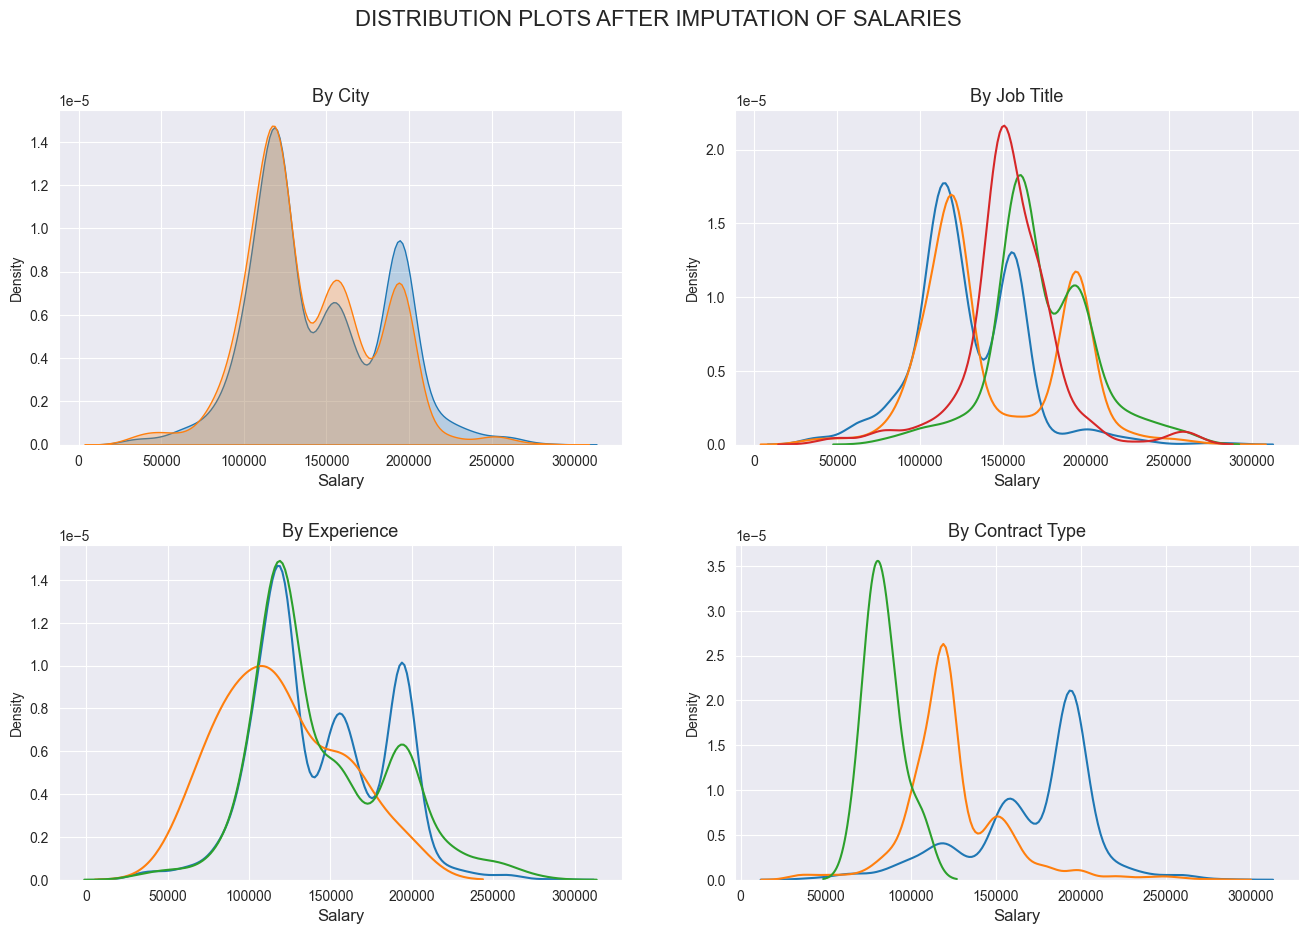

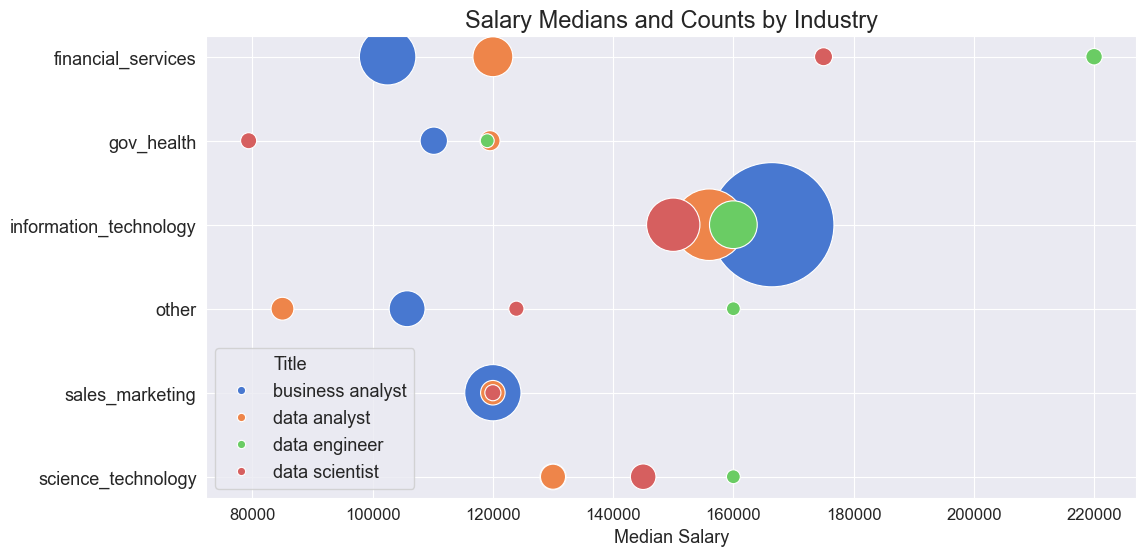

In [23]:
fig, ax = plt.subplots(2,2, figsize=(16,10))

# City comparison
for city in ['Sydney', 'Melbourne']:
    sns.kdeplot(data[data['searched_city'].str.contains(city)]['final_salary'], shade=True, ax=ax[0][0], label=city)
ax[0][0].set_title('By City', fontsize=13)
    
# Job Title comparison    
for job in data['new_job_title'].unique():
    sns.kdeplot(data[data['new_job_title']==job]['final_salary'], shade=False, ax=ax[0][1], label=job)
ax[0][1].set_title('By Job Title', fontsize=13)

# Experience comparison
for exp in data['exp_level'].unique():
    sns.kdeplot(data[data['exp_level']==exp]['final_salary'], shade=0, ax=ax[1][0], label=exp)
ax[1][0].set_title('By Experience', fontsize=13)
    
# Contract comparison
for work in data['work_type'].unique()[:3]:
    sns.kdeplot(data[data['work_type']==work]['final_salary'], shade=0, ax=ax[1][1], label=work)
ax[1][1].set_title('By Contract Type', fontsize=13)

# Bubble plot for overall comparison
grouped_data = pd.DataFrame(data.groupby(['new_category', 'new_job_title'])['final_salary'].median())
grouped_data = pd.concat([grouped_data, data.groupby(['new_category', 'new_job_title'])['work_type'].count()], axis=1)
grouped_data.reset_index(inplace=True)
grouped_data.columns = ['Industry', 'Title', 'Salary', 'Counts']

for a in ax.flat:
    a.set_xlabel('Salary', fontsize=12)

plt.suptitle('DISTRIBUTION PLOTS AFTER IMPUTATION OF SALARIES', fontsize=16)
plt.subplots_adjust(hspace=0.3)

# Bubble plot for grouped data
grouped_data = pd.DataFrame(data.groupby(['new_category', 'new_job_title'])['final_salary'].median())
grouped_data = pd.concat([grouped_data, data.groupby(['new_category', 'new_job_title'])['work_type'].count()], axis=1)
grouped_data.reset_index(inplace=True)
grouped_data.columns = ['Industry', 'Title', 'Salary', 'Counts']

plt.figure(figsize=(12,6))
sns.scatterplot(y='Industry', x='Salary', data=grouped_data, hue='Title', size='Counts', \
                sizes=(100, 8000), alpha=1, palette='muted', legend='brief')
plt.title('Salary Medians and Counts by Industry', fontsize=17)
plt.ylabel('')
plt.xlabel('Median Salary', fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

ax = plt.gca()
h,l = ax.get_legend_handles_labels()
ax.legend(h[:5],l[:5], fontsize=13)

plt.show()

Salary imputations seem to have enhanced the bimodal behaviours of some distributions. This is not ideally the best way to impute salaries, but considering the available limited data there is not much of a choice. For now I will continue with these distributions to make the predictive models.

## 4.0 Next Steps <a name="next"></a>
In this notebook I have covered all basic steps for cleaning the dataset and exploratory analysis. Further, I have also filled the missing salary values with a reasonably logical method using the available data.

The next notebook (Notebook 03) will cover building the models for prediction of salaries and job categories. I will be going over the steps to investigate which factors contribute best to the salaries and to the job categories.

For now, let us save the final dataset as a CSV file to be used for modelling.

In [24]:
for col in data.columns:
    seek[col] = data[col]

seek.to_csv('./datasets/final_data.csv', index=False)

_____________________________________________________________________________
**-- NOTEBOOK 02 END --**